# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План работ

- Загрузить данные.

- Изучить данные. Заполнить пропущенные значения и обработайть аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.

- Подготовить выборки для обучения моделей.

- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.

- Проанализировать время обучения, время предсказания и качество моделей.

- Опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке.

# Описание данных

Датасет содержит следующие данные:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

## Подготовка данных

### Загрузка данных

In [1]:
# Загрузим необходимые библиотеки
!pip install -U scikit-learn -q
!pip install phik -q
!pip install lightgbm -q

In [2]:
# Импортируем нужные библиотеки
import pandas as pd
import os
import numpy as np
import requests
import phik
import time

# Для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt

# Для Машинного обучения
from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

# Загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)

# Метрики
from sklearn.metrics import root_mean_squared_error, mean_squared_error

# Для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Переменные
RANDOM_STATE = 42
TEST_SIZE =0.25

# Отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Путь к данным
pth1 = '/datasets/autos.csv'
pth1_1 = 'https://code.s3.yandex.net/datasets/autos.csv'

# Если файла нет локально - скачиваем его
if not os.path.exists(pth1):
    try:
        response = requests.get(pth1_1)
        os.makedirs(os.path.dirname(pth1), exist_ok=True)
        with open(pth1, 'wb') as f:
            f.write(response.content)
    except Exception as e:
        print(f'Ошибка при загрузке данных: {e}')
        raise
        
# Загружаем данные
try:
    df = pd.read_csv(pth1)
except Exception as e:
    print(f'Ошибка при чтении данных: {e}')
    raise

In [4]:
#Выведем первые строки датафрейма df
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
#Изучим общую информацию об датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
#сохраняем количество строк
old_df_shape = df.shape[0]
old_df_shape

354369

**Вывод:**

В датафрейме 354369 строк. Необходимо откорректировать название столбцов к единому стилю. В некоторых столбцах необходимо поменять тип данных. В некоторых столбцах встречаются пропуски данных. Часть столбцов нужно будет удалить, так как они не влияют на стоимость автомобиля

### Предобработка и исследовательский анализ данных

In [7]:
# Приводим название столбцов к единому стилю 
df.columns = df.columns.str.replace('RegistrationYear','Registration_Year')\
                        .str.replace('Type','_Type')\
                        .str.replace('Gearbox','Gear_box')\
                        .str.replace('LastSeen','Last_Seen')\
                        .str.replace('DateCrawled','Date_Crawled')\
                        .str.replace('RegistrationMonth','Registration_Month')\
                        .str.replace('DateCreated','Date_Created')\
                        .str.replace('NumberOfPicture','Number_Of_Picture')\
                        .str.replace('PostalCode', 'Postal_Code')\
                        .str.lower()

In [8]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'kilometer', 'registration_month',
       'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [9]:
# Переведем столбцы тип данных даты и округлим до дня
date = ['date_crawled', 'date_created', 'last_seen']
df[date] = df[date].apply(lambda x: pd.to_datetime(x).dt.floor('D'))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gear_box            334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [11]:
# Выведем информацию о наличии пропусков
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gear_box              19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [12]:
df[df.isna().any(axis=1)]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05
8,2016-04-04,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04
9,2016-03-17,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354357,2016-03-09,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,2016-03-09,0,18246,2016-04-04
354361,2016-03-09,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09,0,51371,2016-03-13
354364,2016-03-21,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21
354365,2016-03-14,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06


Очень много пропущенных значений. Просто так удалить их нельзя

In [13]:
# Заменим пропуски в датафрйме заглушкой 'unknown'
df=df.fillna('unknown')

In [14]:
# Выведем информацию о наличии пропусков
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gear_box              0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [15]:
# Функция для построения графиков для качественных данных
def print_barh (df_column):
# Построение горизонтальной диаграммы
    ax = df_column.value_counts(ascending=True).plot(
    kind='barh',
    figsize=(15, 10)
)

# Добавление значений рядом со столбцами
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width}',
                    (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center',
                    xytext=(5, 0),
                    textcoords='offset points')

In [16]:
# Функция для построения графиков для количественных данных
def print_hist (df, col, target, name):
    sns.set()
    f, axes = plt.subplots(1, 1, figsize=(17, 5))
    axes.set_title(name, fontsize=12)
    axes.set_ylabel('Количество автомобилей', fontsize=12)
    if target != None:
        sns.histplot(df, bins=25, kde=True, ax=axes, hue=target, x=col)
    else:
        sns.histplot(df, bins=25, kde=True, ax=axes, x=col)
    plt.show();

In [17]:
# функция для построения boxplot
def boxplot (df, col, title, xlabel):
    fig, ax = plt.subplots(figsize = (17,5))
    ax = df[[col]].boxplot(vert = False, ax =ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize = 12);

#### Cтолбец price

Столбец `price` является целевой переменной

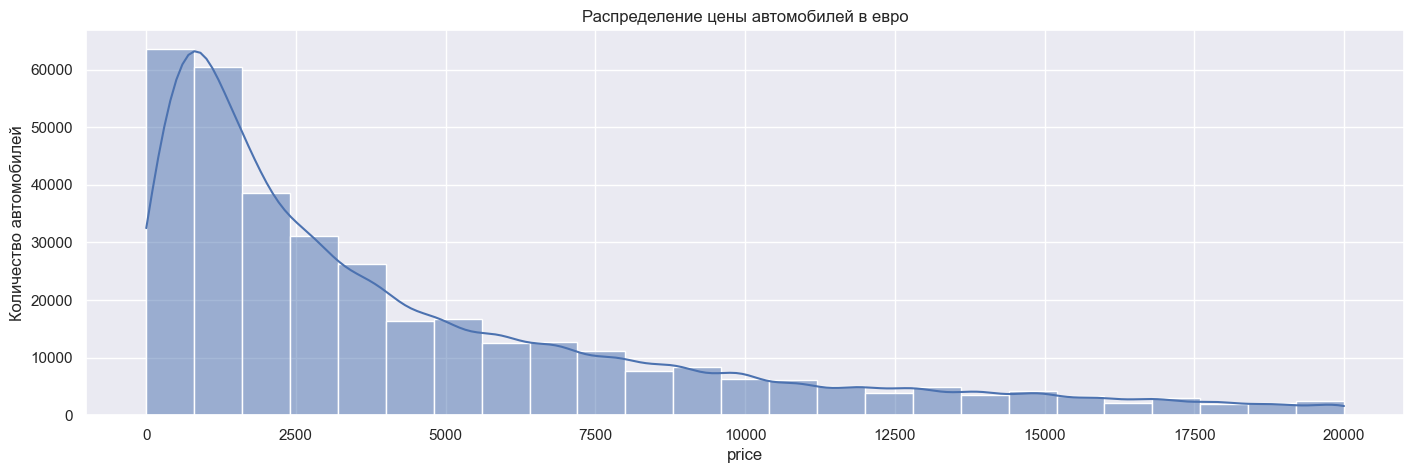

In [18]:
# Выведем гистограмму признака
print_hist(df, 
           'price', 
           None,
           'Распределение цены автомобилей в евро'
          )

In [19]:
df['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

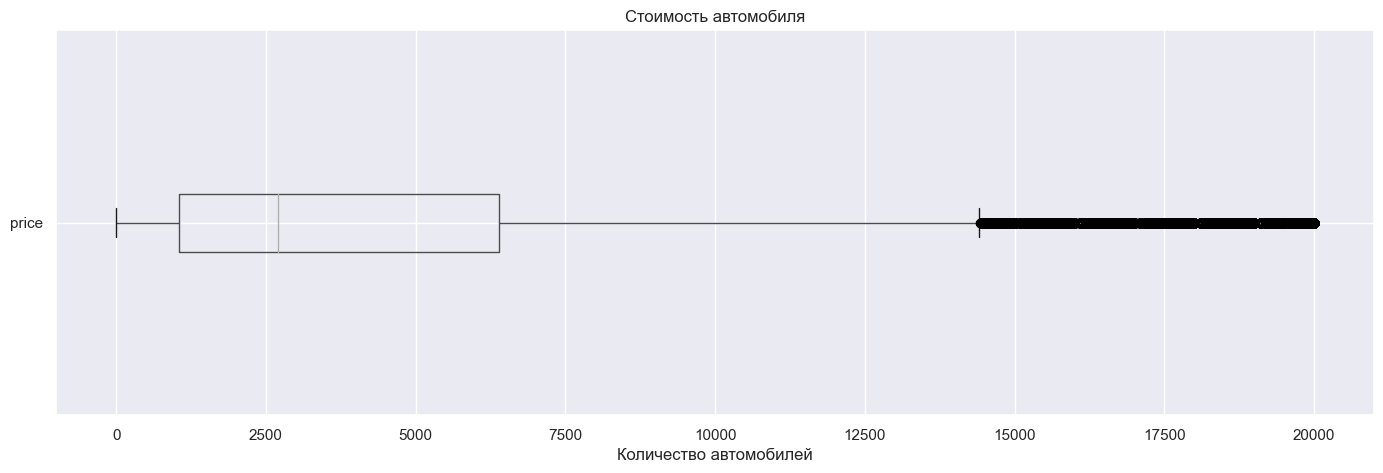

In [20]:
boxplot(df,
        'price', 
        'Стоимость автомобиля',
        'Количество автомобилей'
       )

Много автомобилей с маленькой стоимостью.\
Выберем минимальную стоимость автомобилей ниже которой они стоить не могут

In [21]:
df['price'].quantile(0.05)

200.0

Уберем автомобили стоимостью более 13000

In [22]:
df = df.query('200 <= price <= 13000')

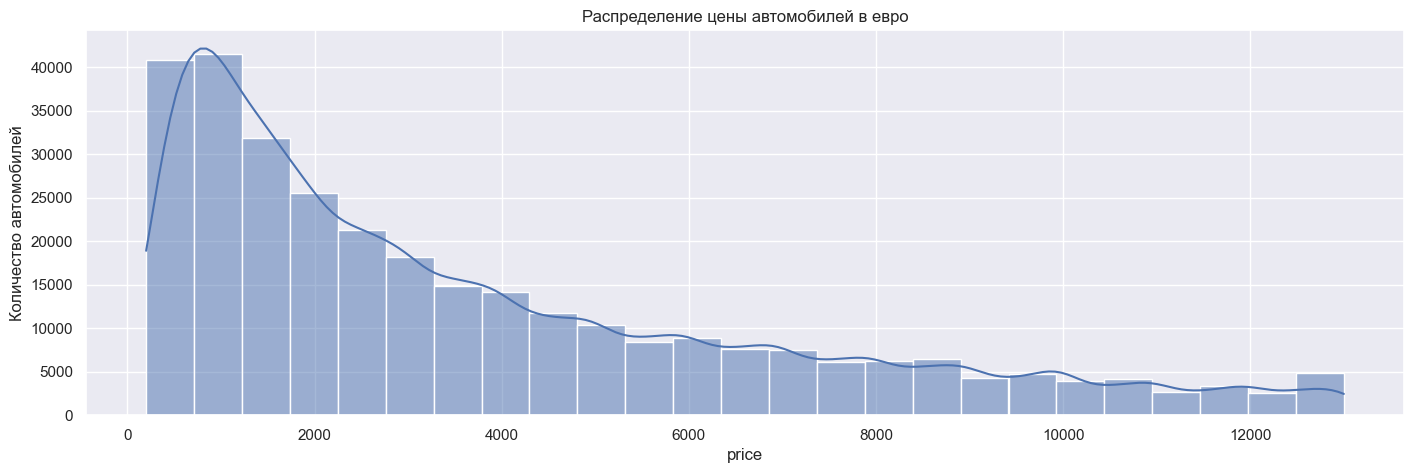

In [23]:
# Выведем гистограмму признака после корректировки
print_hist(df, 
           'price', 
           None,
           'Распределение цены автомобилей в евро'
          )

#### Столбец model

In [24]:
df['model'].value_counts()

golf                  25967
other                 21306
3er                   17439
unknown               15784
polo                  11981
                      ...  
amarok                    3
q3                        3
serie_3                   2
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

In [25]:
# Посмотрим на наличие неявных дубликатов
set(df['model'].unique())

{'100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [26]:
# Есть не явный дубликат. Заменим его
df['model'] = df['model'].replace('rangerover', 'range_rover', regex=True)

In [27]:
# Посмотрим на количество пропусков
df['model'].isna().sum() 

0

#### Столбец vehicle_type

In [28]:
# Изучим столбец 'vehicle_type'
df['vehicle_type'].unique()

array(['unknown', 'suv', 'small', 'sedan', 'convertible', 'wagon', 'bus',
       'coupe', 'other'], dtype=object)

In [29]:
df['vehicle_type'].value_counts()

sedan          81881
small          74488
wagon          58162
unknown        30602
bus            25898
convertible    16779
coupe          12945
suv             8583
other           2864
Name: vehicle_type, dtype: int64

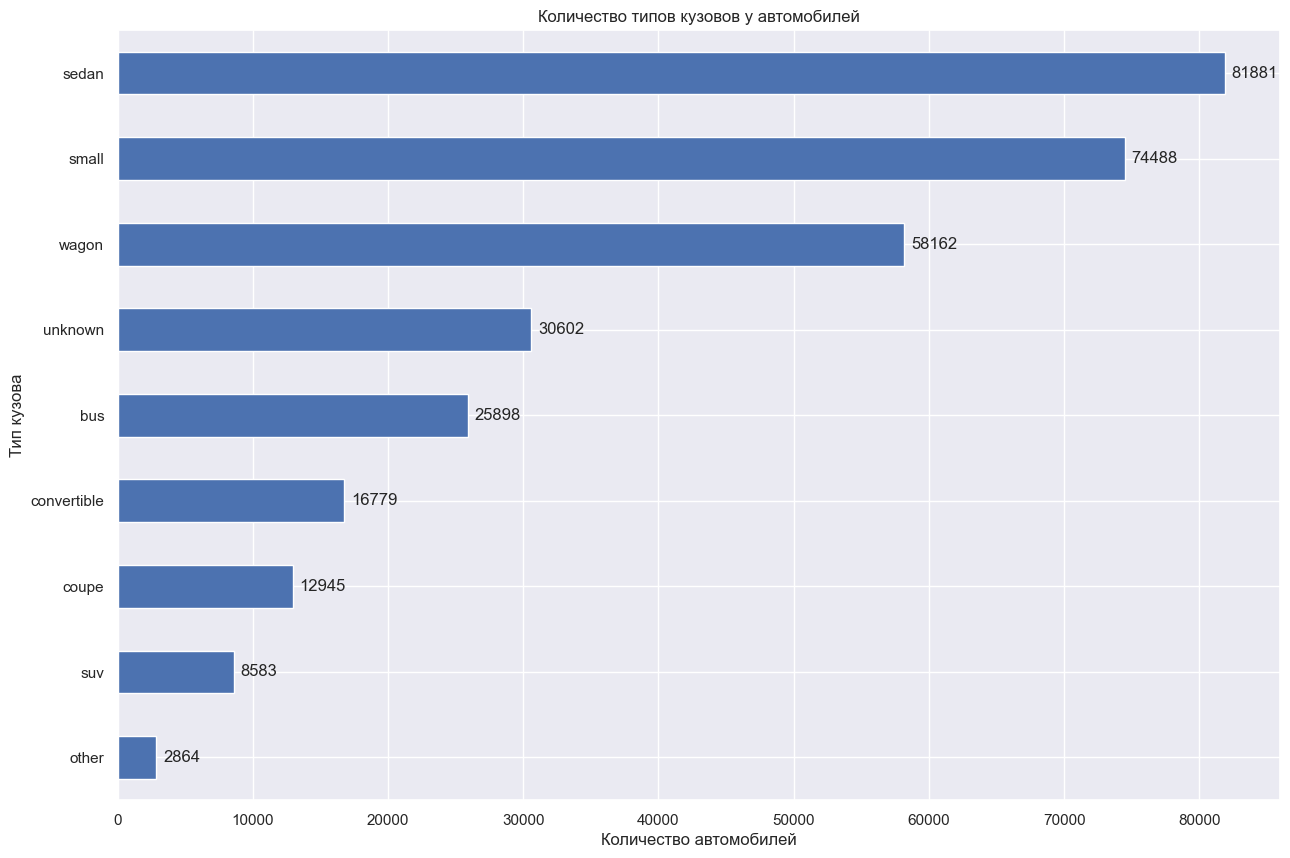

In [30]:
print_barh(df['vehicle_type'])
plt.title('Количество типов кузовов у автомобилей')
plt.xlabel('Количество автомобилей')
plt.ylabel('Тип кузова')
plt.show()

#### Столбец registration_year

In [31]:
# Изучим столбец 'registration_year'
df['registration_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 1998, 2005, 1910, 2016, 2007, 2009,
       2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2010, 2000, 1992, 2013, 1996, 2012, 1989, 2011, 1985, 1982,
       2014, 1976, 1973, 2015, 1969, 1971, 1987, 1983, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1979, 1974, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 3200, 1941, 9999,
       8888, 1500, 2200, 4100, 1962, 1957, 2066, 1940, 2019, 1937, 1951,
       1800, 1959, 1954, 1234, 5300, 9000, 2900, 6000, 1953, 5900, 1000,
       5911, 1400, 5000, 4000, 1952, 8500, 1950, 3700, 3800, 4800, 1942,
       7000, 1956, 1935, 3000, 1923, 2290, 1930, 1001, 9450, 1944, 1929,
       2500, 1938, 1934, 1943, 1928, 5555, 1600, 1111, 1932, 1039, 2800,
       1931, 1948, 4500, 1602, 7800, 1936, 7100, 1300, 8200, 1946],
      dtype=int64)

Год выпуска первого в мире автомобиля с двигателем внутреннего сгорания 1885. Ниже этого года автомобилей быть не может.\
Год выше которого в данных не должно быть в данных посмотрим в столбце `DateCrawled`

In [32]:
# Удалим года которые введены не правильно
# Год выпуска первого в мире автомобиля с двигателем внутреннего сгорания 1885
df = df.query('registration_year > 1885')

In [33]:
# Посмотрим когда были скачаны анкеты
display(df['date_crawled'].min())
display(df['date_crawled'].max())

Timestamp('2016-03-05 00:00:00')

Timestamp('2016-04-07 00:00:00')

Анкеты были скачены с 2016-03-05 по 2016-04-07. Значит позднее даты 2016-04-07 автомобили выпущены не могут быть

In [34]:
# Максимальный год выпуска должен быть не больше 2016 года 4 месяца
df = df.query('registration_year < 2016 or (registration_year == 2016 and registration_month <= 4)')

In [35]:
# Проверим столбец 'registration_year'
df['registration_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 1998, 2005, 1910, 2016, 2007, 2009,
       2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006, 1999, 2010,
       2000, 1992, 2013, 1996, 2012, 1989, 2011, 1985, 1982, 2014, 1976,
       1973, 2015, 1969, 1971, 1987, 1983, 1988, 1980, 1970, 1986, 1965,
       1945, 1925, 1979, 1974, 1955, 1978, 1972, 1968, 1977, 1961, 1966,
       1975, 1963, 1964, 1960, 1958, 1967, 1941, 1962, 1957, 1940, 1937,
       1951, 1959, 1954, 1953, 1952, 1950, 1942, 1956, 1935, 1923, 1930,
       1944, 1929, 1938, 1934, 1943, 1928, 1932, 1931, 1948, 1936, 1946],
      dtype=int64)

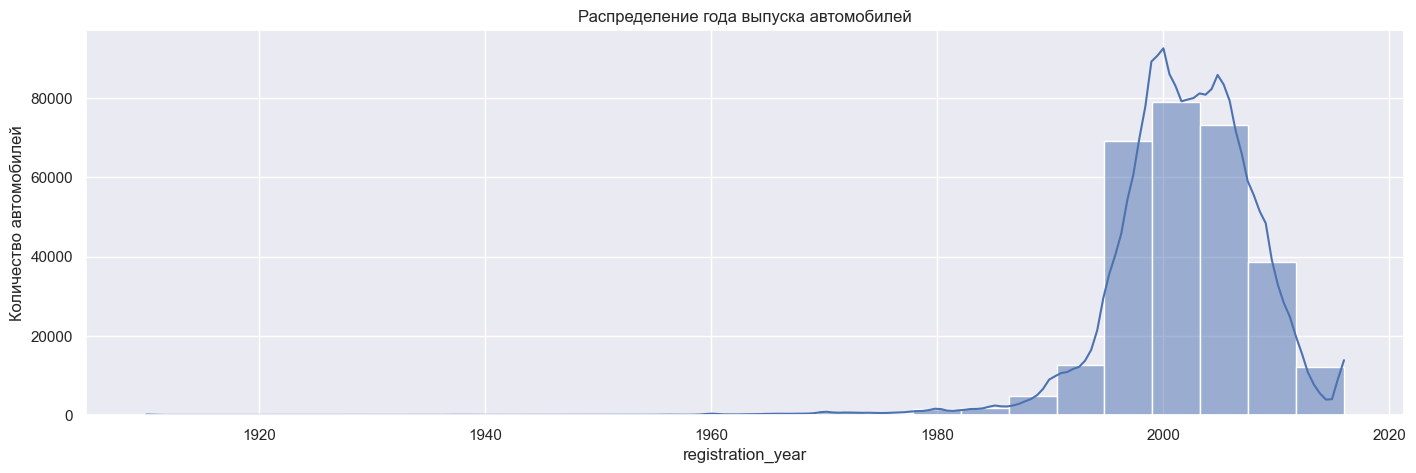

In [36]:
# Выведем гистограмму признака после корректировки
print_hist(df, 
           'registration_year', 
           None,
           'Распределение года выпуска автомобилей'
          )

#### Столбец gear_box

In [37]:
# Изучим столбец 'gear_box'
df['gear_box'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [38]:
df['gear_box'].value_counts()

manual     229984
auto        51621
unknown     13148
Name: gear_box, dtype: int64

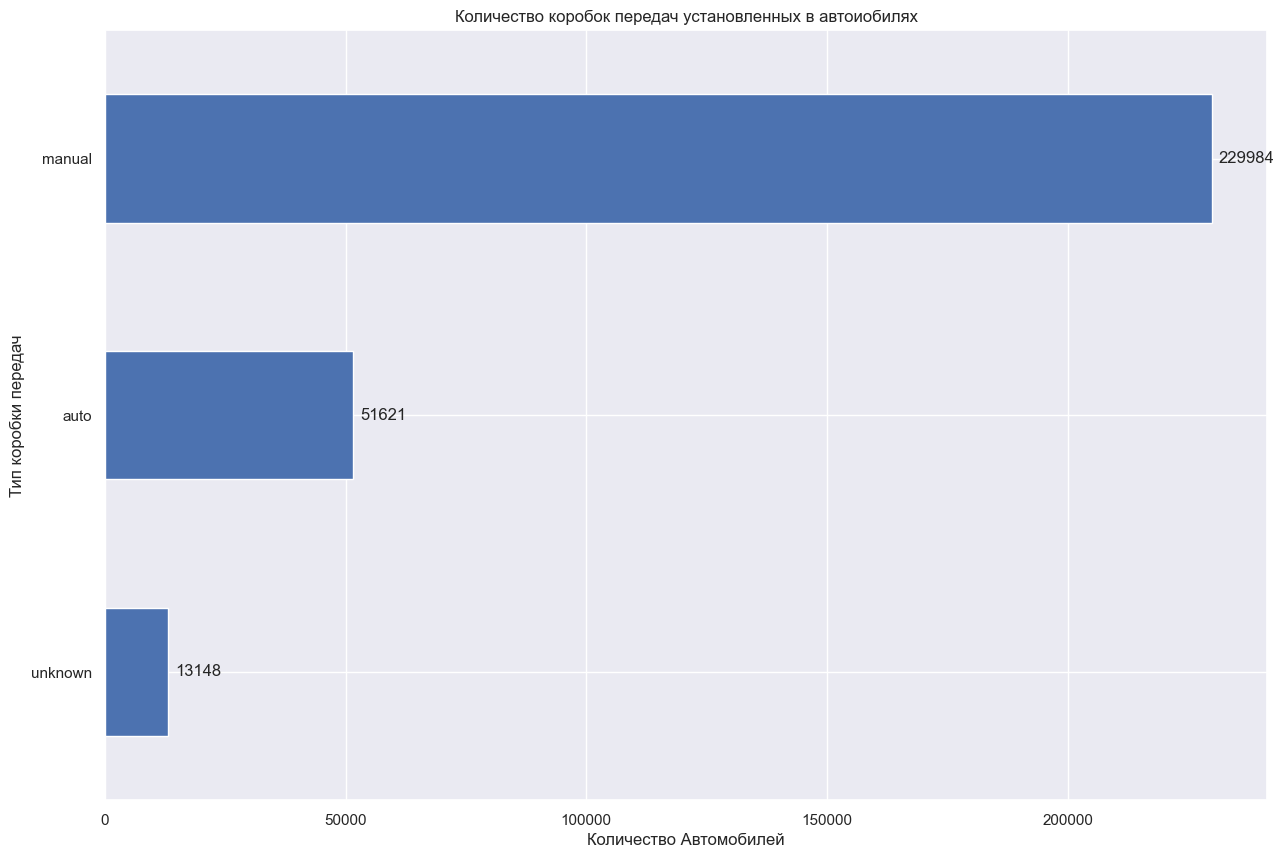

In [39]:
print_barh(df['gear_box'])
plt.title('Количество коробок передач установленных в автоиобилях')
plt.xlabel('Количество Автомобилей')
plt.ylabel('Тип коробки передач')
plt.show()

#### Столбец power

In [40]:
df['power'].describe()

count    294753.000000
mean        108.312764
std         185.935807
min           0.000000
25%          69.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

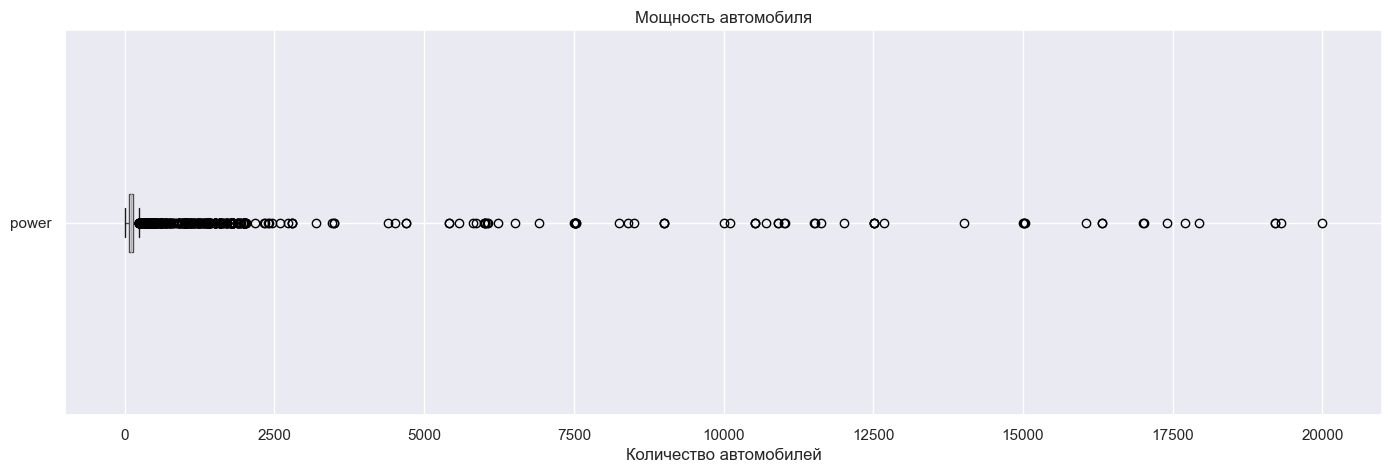

In [41]:
boxplot(df,
        'power', 
        'Мощность автомобиля',
        'Количество автомобилей'
       )

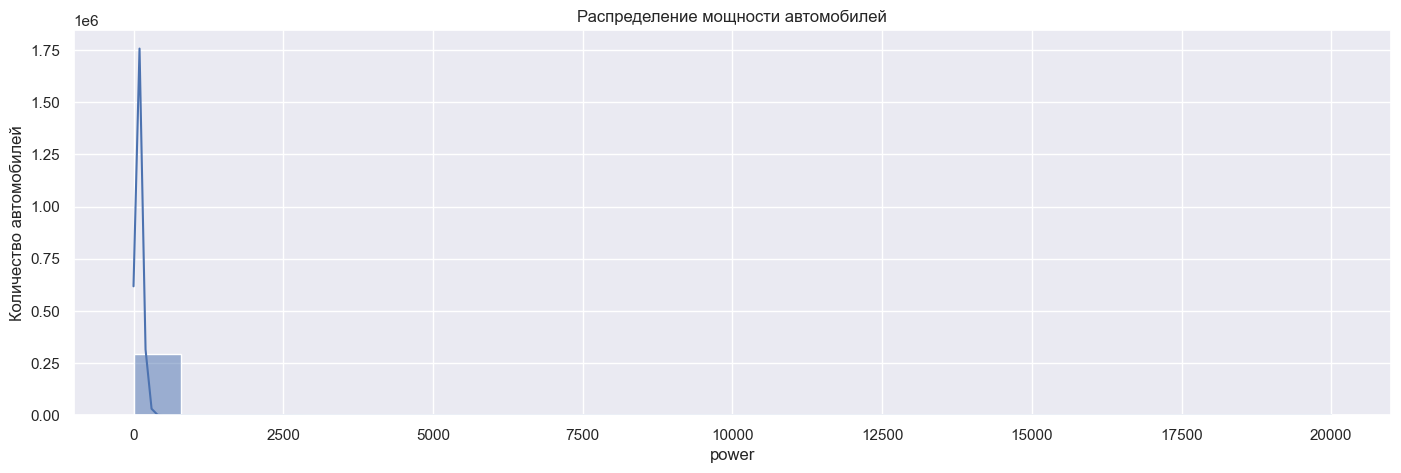

In [42]:
# Выведем гистограмму признака
print_hist(df, 
           'power', 
           None,
           'Распределение мощности автомобилей'
          )

Разброс очень сильный, уберем выбросы больше 600 л.с.

In [43]:
df = df.query('power <= 600')

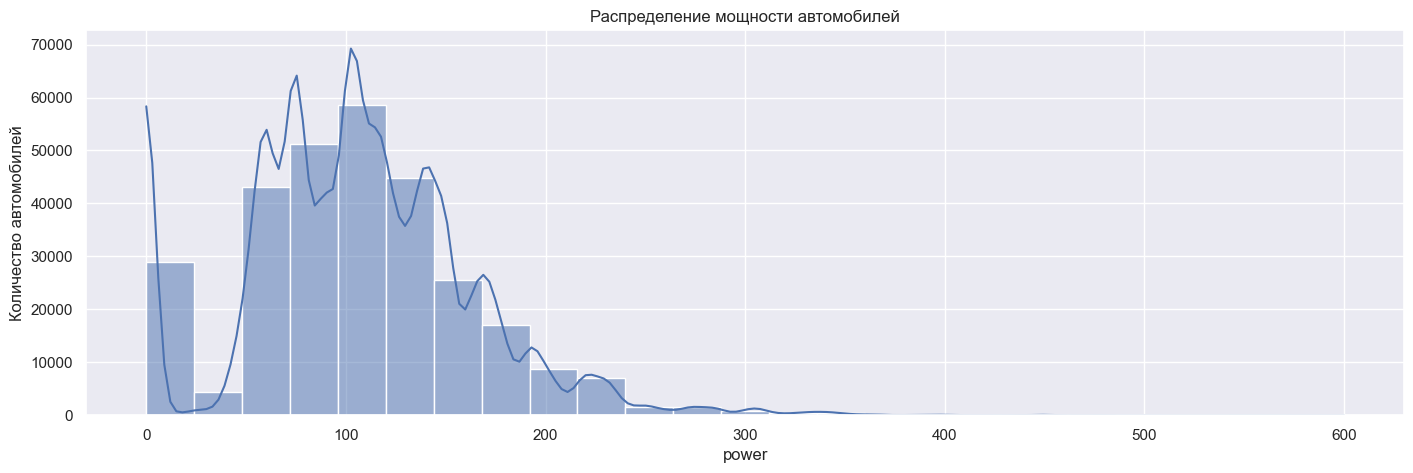

In [44]:
# Выведем гистограмму признака
print_hist(df, 
           'power', 
           None,
           'Распределение мощности автомобилей'
          )

Из графика видно, что многие машины имеют мощность 0. Эти строки ни как не восстановить.\
Удалим данные со значениями мощности менее 40

In [45]:
df = df.query('power >= 40')

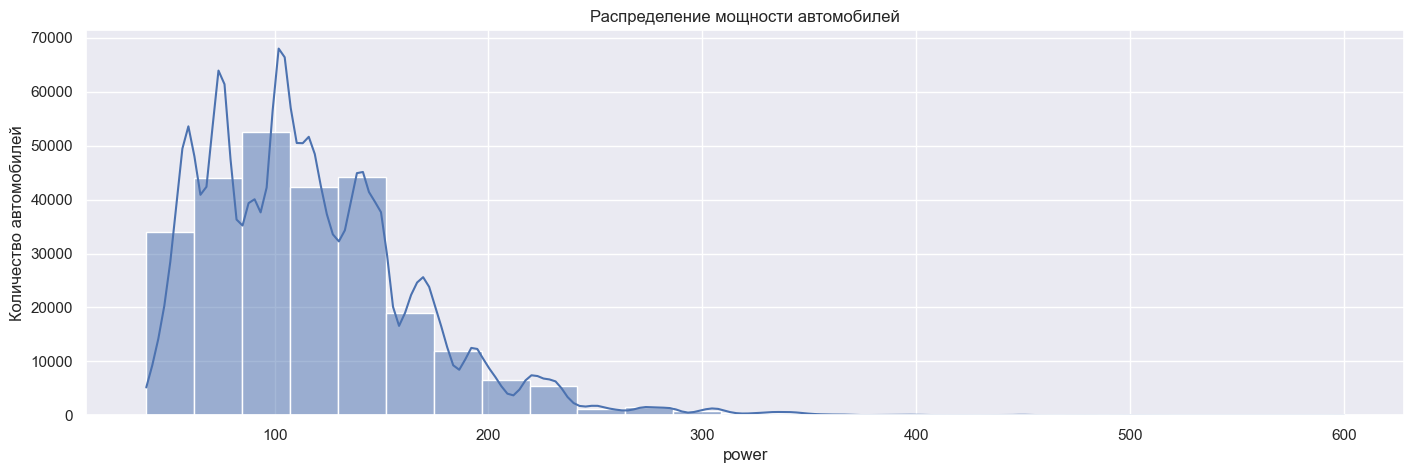

In [46]:
# Выведем гистограмму признака
print_hist(df, 
           'power', 
           None,
           'Распределение мощности автомобилей'
          )

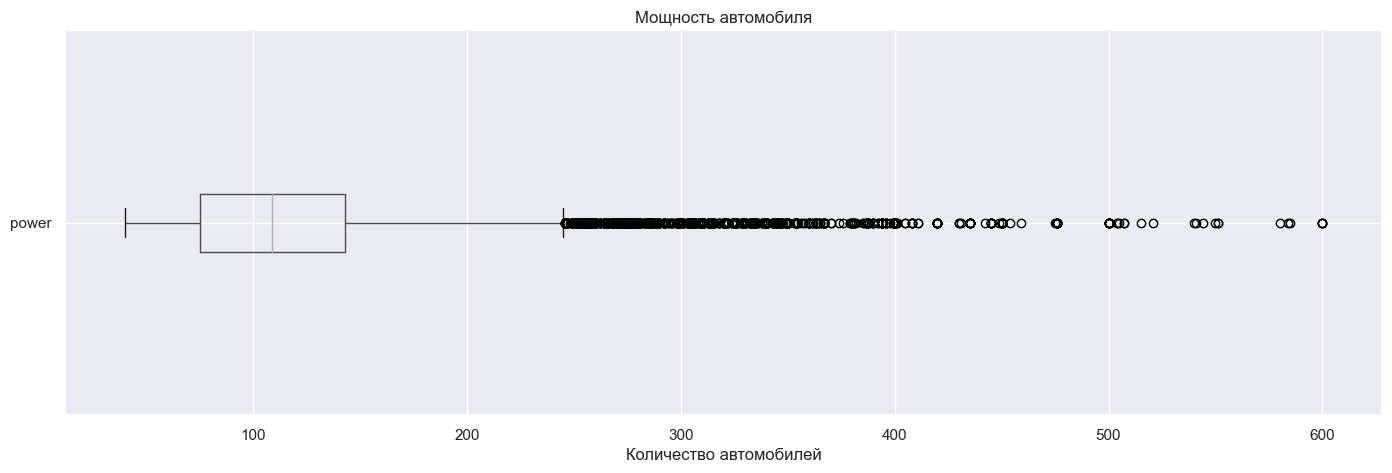

In [47]:
boxplot(df,
        'power', 
        'Мощность автомобиля',
        'Количество автомобилей'
       )

#### Столбец kilometer	

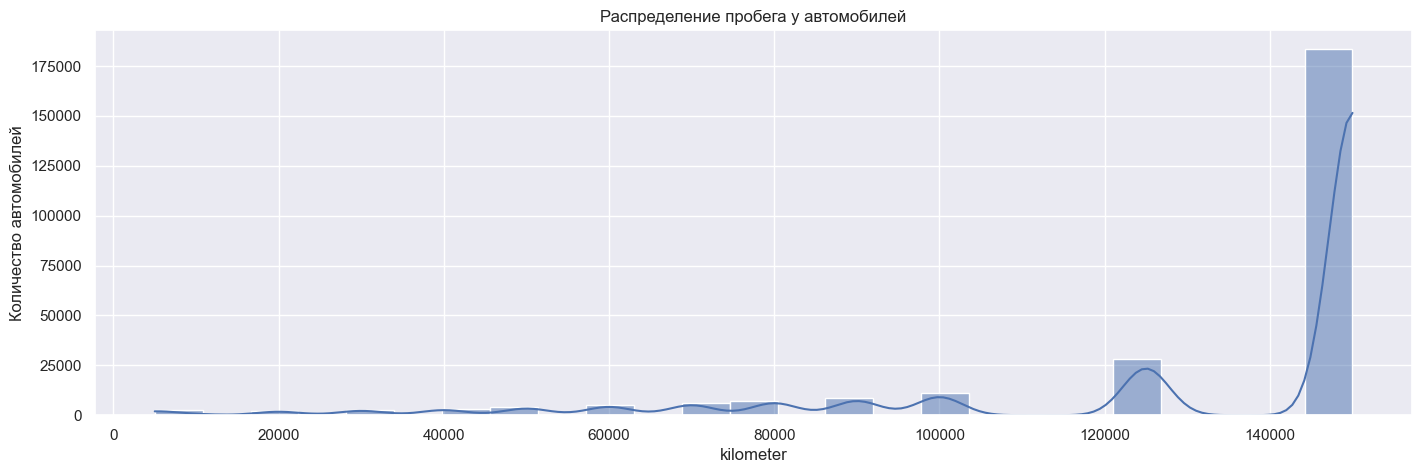

In [48]:
# Выведем гистограмму признака
print_hist(df, 
           'kilometer', 
           None,
           'Распределение пробега у автомобилей'
          )

In [49]:
df['kilometer'].describe()

count    264743.000000
mean     131272.838186
std       34091.437241
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [50]:
df['kilometer'].value_counts()

150000    183732
125000     28382
100000     11000
90000       8597
80000       7295
70000       6042
60000       5050
50000       4031
40000       3088
30000       2634
5000        2277
20000       2112
10000        503
Name: kilometer, dtype: int64

Признак больше похож на категорийный. Разделим его на 4 группы

In [51]:
df['kilometer'] = pd.cut(df['kilometer'], bins=4, labels=['minimal', 'average', 'big', 'very_big'])

df['kilometer'].value_counts()

very_big    212114
big          26892
average      15123
minimal      10614
Name: kilometer, dtype: int64

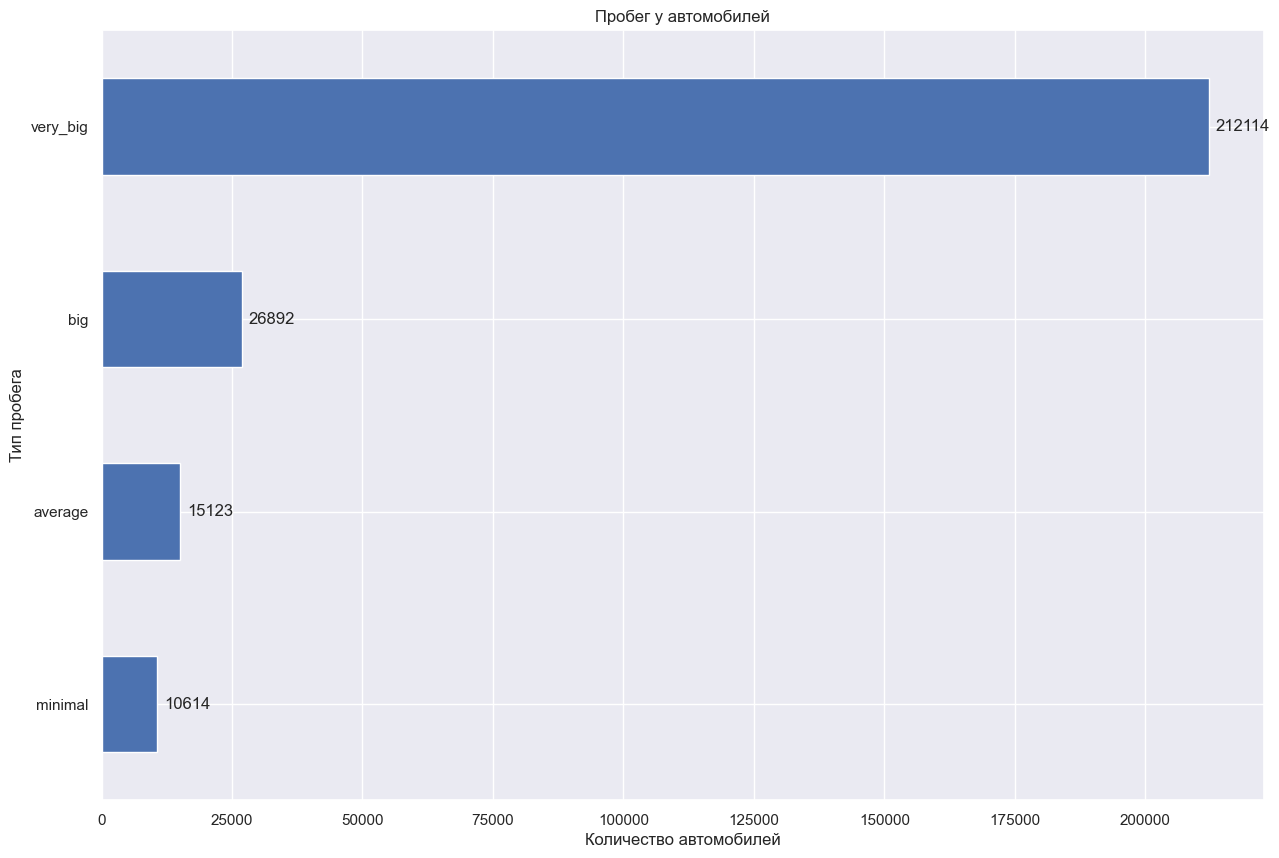

In [52]:
print_barh(df['kilometer'])
plt.title('Пробег у автомобилей')
plt.xlabel('Количество автомобилей')
plt.ylabel('Тип пробега')
plt.show()

#### Столбец fuel_type

In [53]:
# Изучим столбец 'fuel_type'
df['fuel_type'].unique()

array(['gasoline', 'petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

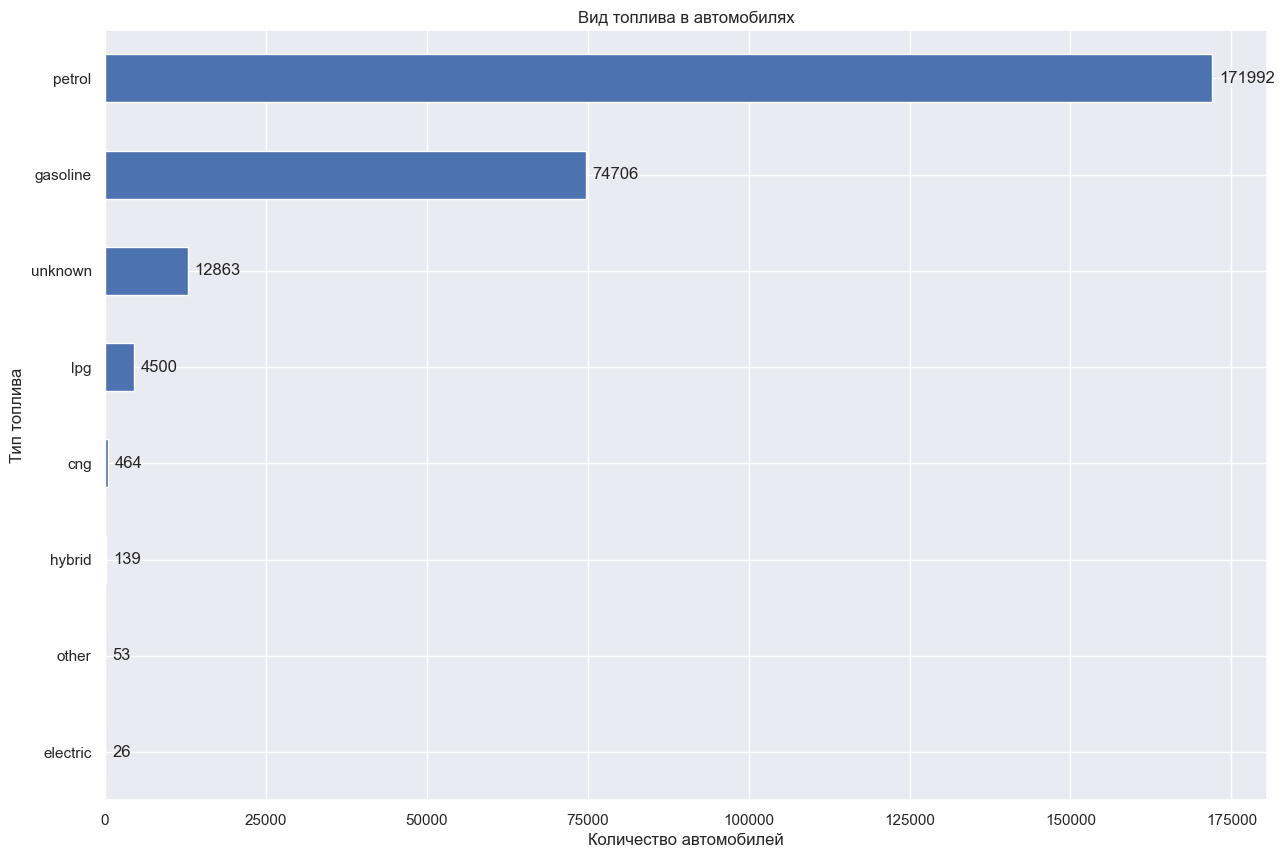

In [54]:
print_barh(df['fuel_type'])
plt.title('Вид топлива в автомобилях')
plt.xlabel('Количество автомобилей')
plt.ylabel('Тип топлива')
plt.show()

#### Столбец brand

In [55]:
# Изучим столбец 'brand'
df['brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'mazda',
       'renault', 'ford', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'nissan', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

In [56]:
# Посмотрим на наличие неявных дубликатов
set(df['brand'].unique())

{'alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo'}

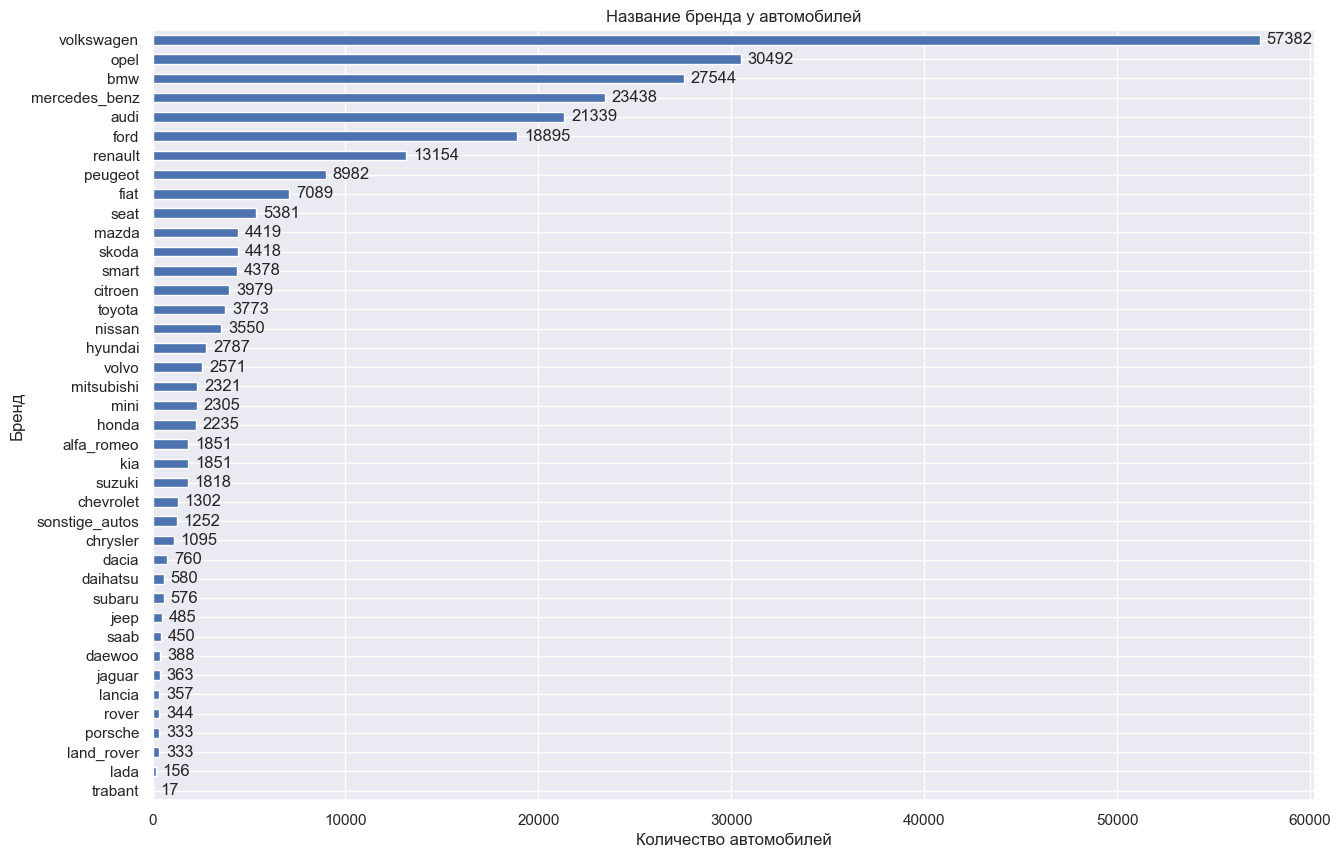

In [57]:
print_barh(df['brand'])
plt.title('Название бренда у автомобилей')
plt.xlabel('Количество автомобилей')
plt.ylabel('Бренд')
plt.show()

#### Столбец repaired

In [58]:
# Изучим столбец 'repaired'
df['repaired'].unique()

array(['unknown', 'no', 'yes'], dtype=object)

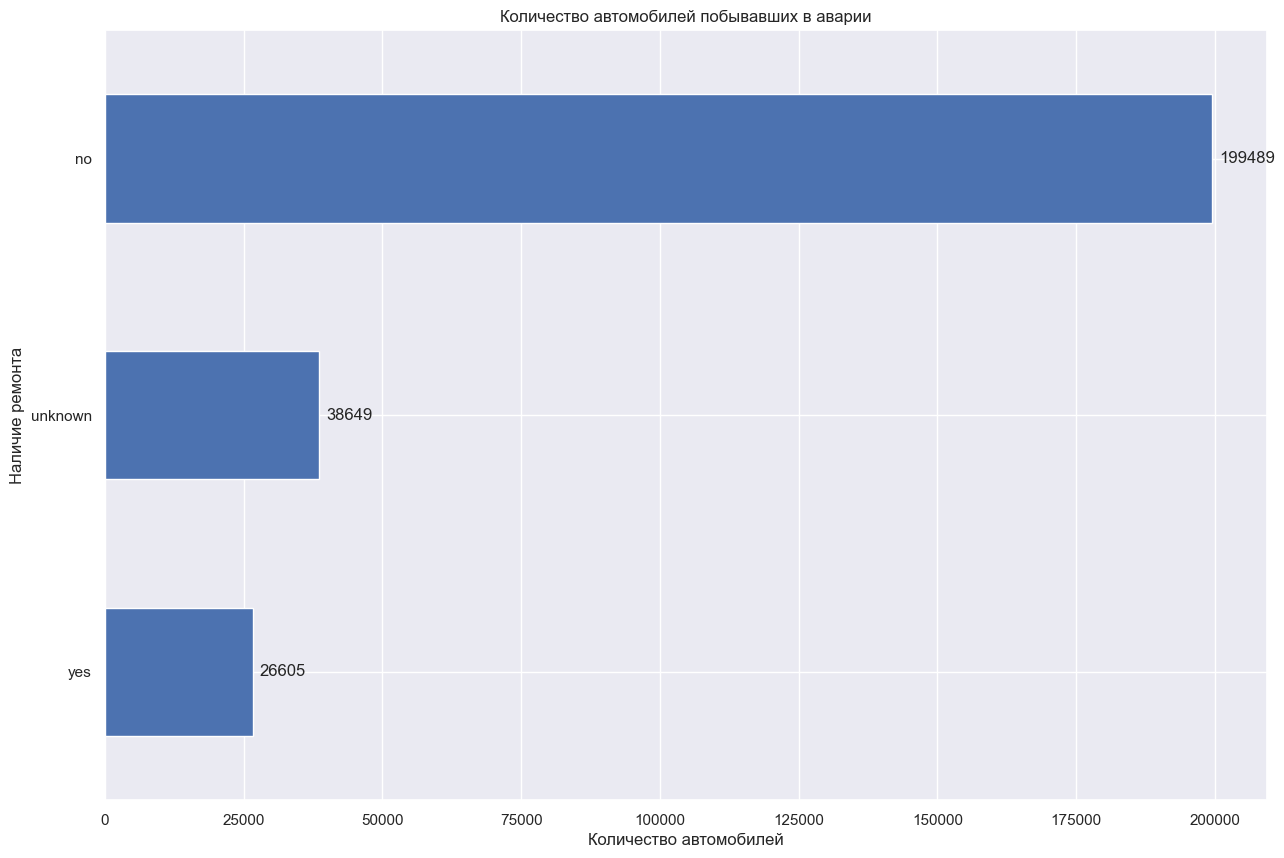

In [59]:
print_barh(df['repaired'])
plt.title('Количество автомобилей побывавших в аварии')
plt.xlabel('Количество автомобилей')
plt.ylabel('Наличие ремонта')
plt.show()

Посмотрим какие столбцы будут не информативны для модели.

`date_crawled` - дата скачивания анкеты из базы. Она ни как не будет влиять на предсказания модели. Удалим ее.\
`registration_year` - год регистрации автомобиля. Будем считать что это год выпуска автомобиля. Сам по себе этот признак не существенно влияет на предсказания модели. Но его можно будет использовать для создания нового признака возраста автомобиля.\
`registration_month` - месяц регистрации автомобиля. Он ни как не будет влиять на предсказания модели. Удалим его.\
`date_created` — дата создания анкеты. Она ни как не будет влиять на предсказания модели. Удалим ее.\
`number_of_pictures` — количество фотографий автомобиля. Количество фотографий не влияет на стоимость автомобиля, а только на скорость его продажи. Удалим его.\
`postal_code` — почтовый индекс владельца анкеты (пользователя). Удалим ее.\
`last_seen` — дата последней активности пользователя. В последней активности пользователь мог изменить стоимость автомобиля. Сам по себе этот признак не существенно влияет на предсказания модели. Но его можно будет использовать для создания нового признака возраста автомобиля.

####  Создание нового столбца age_car

In [60]:
# Создадим новый признак с возрастом автомобиля - `age_car`
df['age_car'] = pd.to_datetime(df['last_seen']).dt.year - df['registration_year']

In [61]:
# Изучим столбец 'age_car'
df['age_car'].unique()

array([ 12,  15,   8,  21,  18,  11,   0,   9,   7,  14,  19,  26,  35,
        13,  25,  32,  10,  17,   6,  16,  24,   3,  22,  20,   4,  27,
         5,  23,  31,  34,   2,  43,   1,  47,  45,  29,  33,  28,  36,
        30,  40,  51,  71,  42,  38,  37,  44,  39,  55,  48,  53,  46,
        61,  58,  75,  50,  41,  56, 106,  57,  52,  54,  49,  63,  65,
        66,  74,  59,  78,  60,  88,  62,  85,  68,  73,  79], dtype=int64)

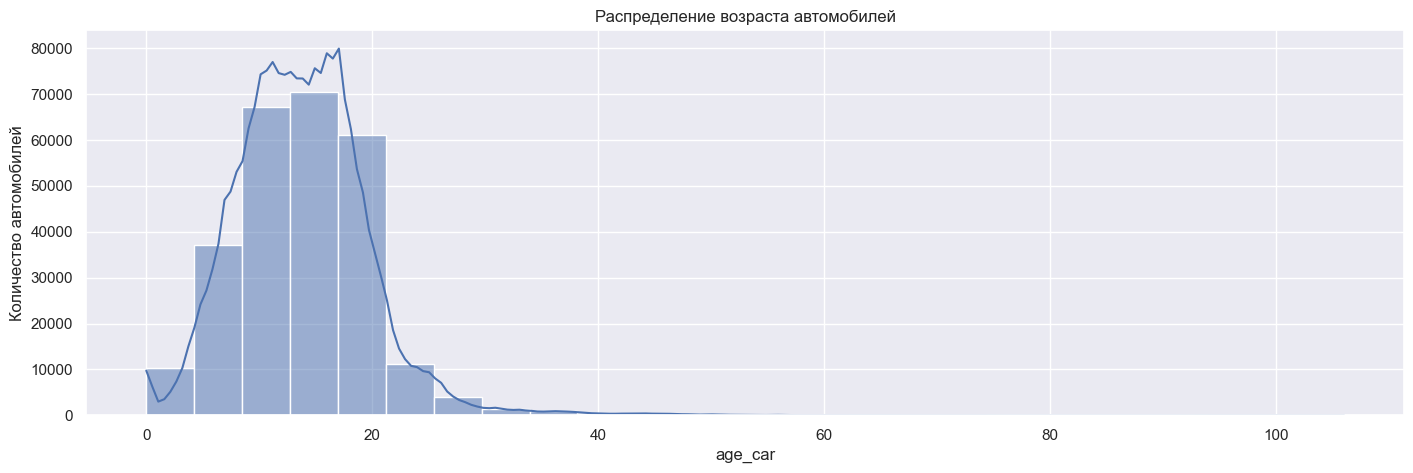

In [62]:
# Выведем гистограмму признака
print_hist(df, 
           'age_car', 
           None,
           'Распределение возраста автомобилей'
          )

In [63]:
# Удалим неинформативные столбцы которые не влияют на предсказания стоимости автомобиля
df = df.drop(columns=['date_crawled',
                      'registration_year',
                      'registration_month',
                      'date_created',
                      'number_of_pictures',
                      'postal_code',
                      'last_seen'
                     ])

**Вывод:**
Откорректировали название столбцов к единому стилю.

В столбце `price` выбрали минимальную стоимость автомобиля 200 евро. Неподходящие данные удалили.

В столбце `vehicle_type` заменили отсутствующие значения самым частым значением по данным сгрупирированным по столбцу `model` и `brand` . Данные в которых не смогли подобрать замену удалили.

В столбце `registration_year` выбрали диапазон дат от 1885 года до 2016-04. Неподходящие данные удалили.

В столбце `gear_box` заменили отсутствующие значения самым частым значением по данным сгрупирированным по столбцу `model` и `brand` . Данные в которых не смогли подобрать замену удалили.

В столбце `power` выбрали диапазон мощности от 40 до 600. Неподходящие данные удалили.

В столбце `model` обработали неявные дубликаты. Неподходящие данные заменили на значение `other`.

В столбце `fuel_type` заменили отсутствующие значения самым частым значением по данным сгрупирированным по столбцу `model` и `brand`.

В столбце `model` неподходящие данные заменили на значение `unknown`.

Создали новый признак `age_car` в котором возраст автомобиля.

После предобработки данных удалили столбцы, которые не влияют на предсказание модели.

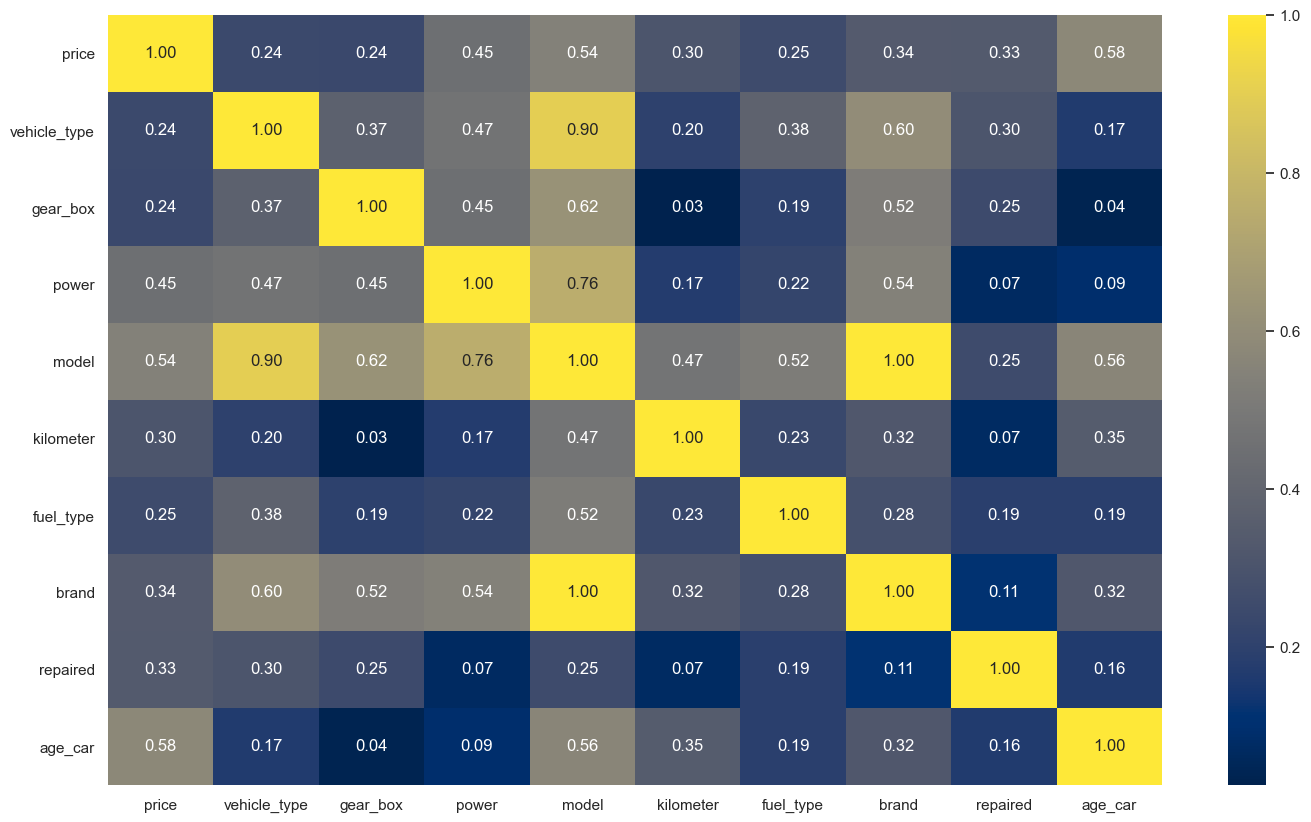

In [64]:
# Коэффициенты корреляции Фи
interval_cols = ['price', 
                 'power', 
                 'age_car'
                ]
plt.figure(figsize=(17, 10))
sns.heatmap(
    df.phik_matrix(verbose=False, interval_cols=interval_cols),#, bins=100),
    annot=True,
    fmt='.2f',
    cmap='cividis'
);

Мультиколениарность наблюдается у признаков `brand` и `model`. Удалим признак `brand`.\
Чуть меньше мультиколениарность наблюдается у признаков `vehicle_type` и `model`. Объединим их в один признак

In [65]:
df['model_vehicle_type'] = df['model'] + '_' + df['vehicle_type']

In [66]:
df = df.drop(columns=['brand',
                      'vehicle_type',
                      'model'
                     ])

In [67]:
df.head()

,price,gear_box,power,kilometer,fuel_type,repaired,age_car,model_vehicle_type
2,9800,auto,163,very_big,gasoline,unknown,12,grand_suv
3,1500,manual,75,very_big,petrol,no,15,golf_small
4,3600,manual,69,big,gasoline,no,8,fabia_small
5,650,manual,102,very_big,petrol,yes,21,3er_sedan
6,2200,manual,109,very_big,petrol,no,12,2_reihe_convertible


In [68]:
#Проверим наличие явных дубликатов
df.duplicated().sum()

40006

In [69]:
df.drop_duplicates(inplace=True)
#Проверим наличие явных дубликатов
df.duplicated().sum()

0

In [70]:
#Посчитаем сколько данных сохранилось после исследовательского анализа данных
new_df_shape = df.shape[0]

print('Количество сохраненных данных {:.2%}'.format(new_df_shape / old_df_shape))

Количество сохраненных данных 63.42%


**Вывод:**

Мультиколениарность наблюдается у признаков `brand` и `model`. Удали признак `brand`.

Чуть меньше мультиколениарность наблюдается у признаков `vehicle_type` и `model`. Объединили их в один признак `model_vehicle_type`. Признаки `vehicle_type` и `model` удалили.

Удалили явные дубликаты.

#### Оптимизация датасета

Попробуем оптимизировать физический размер датасета с помощью функции optimize. \
Функция проверяет минимальную и максимальную длину значений в столбцах. Если значения могут уместиться в типе данных меньшего размера (например, np.int8 вместо np.int16), столбец конвертируется в более компактный тип данных.

In [71]:
def optimize(df):
    # Типы, которые будем проверять на оптимизацию
    
    numerics = ['int16', 'int32', 'int64']
    
    # Размер занимаемой памяти до оптимизации (в Мб)
    before = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
    # Размер занимаемой памяти после оптимизации (в Мб)
    after = df.memory_usage().sum() / 1024**2
    print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before, after, 100 * (before - after) / before))
    return df

In [72]:
# До оптимизации
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224737 entries, 2 to 354368
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               224737 non-null  int64   
 1   gear_box            224737 non-null  object  
 2   power               224737 non-null  int64   
 3   kilometer           224737 non-null  category
 4   fuel_type           224737 non-null  object  
 5   repaired            224737 non-null  object  
 6   age_car             224737 non-null  int64   
 7   model_vehicle_type  224737 non-null  object  
dtypes: category(1), int64(3), object(4)
memory usage: 13.9+ MB


In [73]:
optimize(df)

Размер использования памяти: до 13.93 Mb - после  9.86 Mb (29.2%)


,price,gear_box,power,kilometer,fuel_type,repaired,age_car,model_vehicle_type
2,9800,auto,163,very_big,gasoline,unknown,12,grand_suv
3,1500,manual,75,very_big,petrol,no,15,golf_small
4,3600,manual,69,big,gasoline,no,8,fabia_small
5,650,manual,102,very_big,petrol,yes,21,3er_sedan
6,2200,manual,109,very_big,petrol,no,12,2_reihe_convertible
...,...,...,...,...,...,...,...,...
354357,1690,manual,55,very_big,petrol,unknown,12,fabia_wagon
354362,3200,manual,225,very_big,petrol,yes,12,leon_sedan
354366,1199,auto,101,very_big,petrol,no,16,fortwo_convertible
354367,9200,manual,102,very_big,gasoline,no,20,transporter_bus


In [74]:
# После оптимизации
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224737 entries, 2 to 354368
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               224737 non-null  int16   
 1   gear_box            224737 non-null  object  
 2   power               224737 non-null  int16   
 3   kilometer           224737 non-null  category
 4   fuel_type           224737 non-null  object  
 5   repaired            224737 non-null  object  
 6   age_car             224737 non-null  int8    
 7   model_vehicle_type  224737 non-null  object  
dtypes: category(1), int16(2), int8(1), object(4)
memory usage: 9.9+ MB


**Вывод:**

Уменьшен объем используемой памяти датасетом.

## Обучение моделей

Выберем следующие регрессоры для обучения модели:

- Ridge
- DecisionTreeRegressor
- CatBoostRegressor
- LightGBMRegressor

В качестве метрики для всех моделей будем использовать RMSE

### Подготовка данных

In [75]:
# Сохранение признаков
X = df.drop('price', axis=1)
y = df['price']

In [76]:
# Разделим признаки на категорийные и численные
cat_column = ['gear_box', 'model_vehicle_type', 'fuel_type', 'repaired', 'kilometer']
num_column = ['power', 'age_car']

In [77]:
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE
)


In [78]:
# Создадим пайплайн для кодирования
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
]) 

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_column),
    ('num', StandardScaler(), num_column)
], remainder='passthrough') 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])


In [79]:
%whos

Variable                  Type                 Data/Info
--------------------------------------------------------
CatBoostRegressor         type                 <class 'catboost.core.CatBoostRegressor'>
ColumnTransformer         ABCMeta              <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
DecisionTreeRegressor     ABCMeta              <class 'sklearn.tree._cla<...>s.DecisionTreeRegressor'>
LGBMRegressor             type                 <class 'lightgbm.sklearn.LGBMRegressor'>
MinMaxScaler              type                 <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
OneHotEncoder             type                 <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
Pipeline                  ABCMeta              <class 'sklearn.pipeline.Pipeline'>
Pool                      type                 <class 'catboost.core.Pool'>
RANDOM_STATE              int                  42
RandomizedSearchCV        ABCMeta              <class 'sklearn.model_sel<...>arch.Random

In [80]:
del df, print_barh, print_hist, phik, sns, requests, pth1_1, pth1, plt, optimize, old_df_shape, new_df_shape, boxplot, X, y

In [81]:
# Определяем параметры для каждой модели
param_distributions_ridge = {
    'models': [Ridge(random_state=RANDOM_STATE)],
    'models__alpha': [0.1, 1.0, 10.0]
}

param_distributions_tree = {
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': list(range(2, 20)),
    'models__max_features': list(range(2, 20)),
    'models__min_samples_split': list(range(2, 20)),
    'models__min_samples_leaf': list(range(2, 20))
}

param_distributions_catboost = {
    'models': [CatBoostRegressor(random_seed=RANDOM_STATE, verbose=0)],
    'models__iterations': [100, 200],
    'models__learning_rate': [0.1, 0.3]
}

param_distributions_lgbm = {
    'models': [LGBMRegressor(random_state=RANDOM_STATE)],
    'models__num_leaves': [10, 50],
    'models__learning_rate': [0.01, 0.1],
    'models__n_estimators': [100, 200]
}

# Создаем список моделей для поиска
models_to_search = [
    ('Ridge', param_distributions_ridge, 5),
    ('DecisionTree', param_distributions_tree, 10),
    ('CatBoost', param_distributions_catboost, 5),
    ('LGBM', param_distributions_lgbm, 10)
]

# Словари для хранения результатов
all_results = []
best_models = {}

print("НАЧАЛО ПОИСКА ГИПЕРПАРАМЕТРОВ ДЛЯ МОДЕЛЕЙ")

# Проходим по всем моделям
for model_name, param_distributions, n_iter in models_to_search:
    print(f"\n{'='*60}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"ИТЕРАЦИЙ: {n_iter}")
    print(f"{'='*60}")
    
    try:
        randomized_search = RandomizedSearchCV(
            estimator=pipe_final, 
            param_distributions=param_distributions, 
            scoring='neg_root_mean_squared_error', 
            random_state=RANDOM_STATE,
            n_jobs=1,
            n_iter=n_iter,
            cv=5, 
            error_score="raise",
            verbose=1,
            return_train_score=True
        )
        
        print(f"Запуск кросс-валидации для {model_name}...")
        randomized_search.fit(X_train, y_train)
        
        # Получаем результаты CV
        cv_results = pd.DataFrame(randomized_search.cv_results_)
        
        # Добавляем информацию о модели
        cv_results['model_name'] = model_name
        
        # Сохраняем лучшую модель
        best_models[model_name] = randomized_search.best_estimator_
        
        # Добавляем в общий DataFrame
        all_results.append(cv_results)
        
        # Выводим статистику
        print(f"\n{model_name} обучена успешно!")
        print(f"Лучшая RMSE (CV): {abs(randomized_search.best_score_):.4f}")
        print(f"Лучшие параметры: {randomized_search.best_params_}")
        
    except Exception as e:
        print(f"Ошибка при обучении {model_name}: {e}")

print("ПОИСК ГИПЕРПАРАМЕТРОВ МОДЕЛЕЙ ЗАВЕРШЕН")

НАЧАЛО ПОИСКА ГИПЕРПАРАМЕТРОВ ДЛЯ МОДЕЛЕЙ

МОДЕЛЬ: Ridge
ИТЕРАЦИЙ: 5
Запуск кросс-валидации для Ridge...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Ridge обучена успешно!
Лучшая RMSE (CV): 1996.0702
Лучшие параметры: {'models__alpha': 1.0, 'models': Ridge(random_state=42)}

МОДЕЛЬ: DecisionTree
ИТЕРАЦИЙ: 10
Запуск кросс-валидации для DecisionTree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

DecisionTree обучена успешно!
Лучшая RMSE (CV): 2861.4344
Лучшие параметры: {'models__min_samples_split': 16, 'models__min_samples_leaf': 2, 'models__max_features': 16, 'models__max_depth': 19, 'models': DecisionTreeRegressor(random_state=42)}

МОДЕЛЬ: CatBoost
ИТЕРАЦИЙ: 5
Запуск кросс-валидации для CatBoost...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

CatBoost обучена успешно!
Лучшая RMSE (CV): 1399.4956
Лучшие параметры: {'models__learning_rate': 0.3, 'models__iterations': 200, 'models': <catboost.core.CatBoostRegressor object at 0x000001E13

In [82]:
# Объединяем все результаты
final_results = pd.concat(all_results, ignore_index=True)
    
# Выбираем нужные колонки
columns_to_keep = [
    'model_name',
    'params',
    'mean_test_score',
    'mean_fit_time',
    'mean_score_time',
    'rank_test_score'
]
    
# Фильтруем только нужные колонки
available_columns = [col for col in columns_to_keep if col in final_results.columns]
final_results = final_results[available_columns]
    
# Преобразуем RMSE из отрицательных значений
final_results['mean_test_rmse'] = abs(final_results['mean_test_score'])
    
# Сортируем по качеству
final_results_sorted = final_results.sort_values('mean_test_rmse')
    
print(f"\n{'='*80}")
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ПО ВСЕМ МОДЕЛЯМ")
print(f"{'='*80}")
    
# Выводим топ-5 результатов
print("\nТОП-5 ЛУЧШИХ КОНФИГУРАЦИЙ:")
top_5 = final_results_sorted.head(5)[[
    'model_name', 'mean_test_rmse', 'mean_fit_time', 'mean_score_time', 'params'
]]
print(top_5.to_string(index=False))


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ПО ВСЕМ МОДЕЛЯМ

ТОП-5 ЛУЧШИХ КОНФИГУРАЦИЙ:
model_name  mean_test_rmse  mean_fit_time  mean_score_time                                                                                                                              params
      LGBM     1361.229404       5.961865         1.123919     {'models__num_leaves': 50, 'models__n_estimators': 200, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}
      LGBM     1396.372111       4.760153         0.895778     {'models__num_leaves': 50, 'models__n_estimators': 100, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}
  CatBoost     1399.495633      89.340687        22.103816 {'models__learning_rate': 0.3, 'models__iterations': 200, 'models': <catboost.core.CatBoostRegressor object at 0x000001E13D4A3BE0>}
  CatBoost     1455.939103     103.670666        22.700247 {'models__learning_rate': 0.3, 'models__iterations': 100, 'models': <catboost.core.CatBoostRegressor obj

**Вывод:**

Подобраны гипермараметры используемых моделей

## Анализ моделей

In [83]:
# Выбор лучшей модели по качеству кросс-валидации
print("ВЫБОР ЛУЧШЕЙ МОДЕЛИ ПО КАЧЕСТВУ КРОСС-ВАЛИДАЦИИ")

# Создаем DataFrame для сравнения моделей на основе final_results
comparison_data = []
unique_models = final_results['model_name'].unique()

for model_name in unique_models:
    # Берем лучший результат для каждой модели (с наименьшим RMSE)
    model_results = final_results[final_results['model_name'] == model_name]
    best_result = model_results.loc[model_results['mean_test_rmse'].idxmin()]
    
    comparison_data.append({
        'Модель': model_name,
        'RMSE_CV': best_result['mean_test_rmse'],
        'Лучшие_параметры': best_result['params'],
        'Время_обучения_сек': best_result['mean_fit_time'],
        'Время_предсказания_сек': best_result['mean_score_time']
    })

if comparison_data:
    # Создаем DataFrame
    scores_data = pd.DataFrame(comparison_data)
    
    # Вычисляем рейтинги для каждой метрики
    scores_data['Рейтинг RMSE'] = (scores_data['RMSE_CV'].min() / 
                                  scores_data['RMSE_CV'])
    
    scores_data['Рейтинг времени обучения'] = (scores_data['Время_обучения_сек'].min() / 
                                             scores_data['Время_обучения_сек'])
    
    scores_data['Рейтинг времени предсказания'] = (scores_data['Время_предсказания_сек'].min() / 
                                                 scores_data['Время_предсказания_сек'])
    
    # Итоговый рейтинг
    scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                      scores_data['Рейтинг времени обучения'] +
                                      scores_data['Рейтинг времени предсказания'])
    
    # Сортируем по итоговому рейтингу (чем выше - тем лучше)
    scores_data = scores_data.sort_values('Итоговый рейтинг', ascending=False)
    
    print("Рейтинг моделей по комбинированной оценке:")
    display_cols = ['Модель', 'RMSE_CV', 'Время_обучения_сек', 'Время_предсказания_сек', 
                   'Рейтинг RMSE', 'Рейтинг времени обучения', 'Рейтинг времени предсказания', 'Итоговый рейтинг']
    print(scores_data[display_cols].round(4).to_string(index=False))
    
    # Выбираем лучшую модель по итоговому рейтингу
    best_model_name = scores_data.iloc[1]['Модель']
    best_rmse = scores_data.iloc[1]['RMSE_CV']
    best_params = scores_data.iloc[1]['Лучшие_параметры']
    best_training_time = scores_data.iloc[1]['Время_обучения_сек']
    best_prediction_time = scores_data.iloc[1]['Время_предсказания_сек']
    
    print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    print(f"Итоговый рейтинг: {scores_data.iloc[1]['Итоговый рейтинг']:.4f}")
    print(f"RMSE на кросс-валидации: {best_rmse:.4f}")
    print(f"Время обучения: {best_training_time:.2f} сек")
    print(f"Время предсказания: {best_prediction_time:.4f} сек")
    print(f"Параметры лучшей модели: {best_params}")
    
else:
    print("Ни одна модель не была успешно обучена")
    
print("ВЫБОР МОДЕЛИ ЗАВЕРШЕН")

ВЫБОР ЛУЧШЕЙ МОДЕЛИ ПО КАЧЕСТВУ КРОСС-ВАЛИДАЦИИ
Рейтинг моделей по комбинированной оценке:
      Модель   RMSE_CV  Время_обучения_сек  Время_предсказания_сек  Рейтинг RMSE  Рейтинг времени обучения  Рейтинг времени предсказания  Итоговый рейтинг
        LGBM 1361.2294              5.9619                  1.1239        1.0000                    0.8250                        0.6741            2.4990
DecisionTree 2861.4344              4.9183                  0.8034        0.4757                    1.0000                        0.9430            2.4187
       Ridge 1996.0702              8.7727                  0.7576        0.6820                    0.5606                        1.0000            2.2426
    CatBoost 1399.4956             89.3407                 22.1038        0.9727                    0.0551                        0.0343            1.0620

ЛУЧШАЯ МОДЕЛЬ: DecisionTree
Итоговый рейтинг: 2.4187
RMSE на кросс-валидации: 2861.4344
Время обучения: 4.92 сек
Время предсказания: 

**Вывод:**

Лучшая модель по параметрам скорости обучения и предсказания стала DecisionTree, но значения RMSE выше порога в 2500 еврою\
Берем модель со второго места Ridge у неё лучше RMSE, но скорость обучения дольше.\
Точности моделей CatBoost и LGBM намного лучше, но скорости обучения и предсказания на много больше

### Качество на тестовой выборке для лучшей модели

Проведем обучение тестовой выборки на лучшей модели и замерим скорость выполнения кода

In [84]:
# Выбираем модель Ridge (вторая в списке после DecisionTree)
ridge_model = best_models['Ridge']

In [85]:
%%time
# Предсказание на тестовых данных
y_pred_ridge = ridge_model.predict(X_test)

CPU times: total: 969 ms
Wall time: 2.22 s


In [86]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print('Метрика RMSE на тестовых данных для модели:\n', rmse)

Метрика RMSE на тестовых данных для модели:
 1963.2394306131534


**Вывод:**

Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor. Сочетания скорости на подготовленных данных выводит его в лидеры рейтинга, но точность у него значительно хуже.

Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет CatBoostRegressor и LinearRegression занимает третье место.

## Общий вывод

В датафрейме 354369 строк. Необходимо откорректировать название столбцов к единому стилю. В некоторых столбцах необходимо поменять тип данных. В некоторых столбцах встречаются пропуски данных. Часть столбцов нужно будет удалить, так как они не влияют на стоимость автомобиля.

**Вывод:**
Откорректировали название столбцов к единому стилю.

В столбце `price` выбрали минимальную стоимость автомобиля 200 евро. Неподходящие данные удалили.

В столбце `vehicle_type` заменили отсутствующие значения самым частым значением по данным сгрупирированным по столбцу `model` и `brand` . Данные в которых не смогли подобрать замену удалили.

В столбце `registration_year` выбрали диапазон дат от 1885 года до 2016-04. Неподходящие данные удалили.

В столбце `gear_box` заменили отсутствующие значения самым частым значением по данным сгрупирированным по столбцу `model` и `brand` . Данные в которых не смогли подобрать замену удалили.

В столбце `power` выбрали диапазон мощности от 40 до 600. Неподходящие данные удалили.

В столбце `model` обработали неявные дубликаты. Неподходящие данные заменили на значение `other`.

В столбце `fuel_type` заменили отсутствующие значения самым частым значением по данным сгрупирированным по столбцу `model` и `brand`.

В столбце `model` неподходящие данные заменили на значение `unknown`.

Создали новый признак `age_car` в котором возраст автомобиля.

После предобработки данных удалили столбцы, которые не влияют на предсказание модели.

Удалили явные дубликаты.

Уменьшен объем используемой памяти датасетом.\
Построена матрица корреляции. Мультиколениарность не наблюдается

Подобраны гипермараметры используемых моделей

Лучшая модель по параметрам скорости обучения и предсказания стала DecisionTree, но значения RMSE выше порога в 2500 еврою
Берем модель со второго места Ridge у неё лучше RMSE, но скорость обучения дольше.
Точности моделей CatBoost и LGBM намного лучше, но скорости обучения и предсказания на много больше

Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет CatBoostRegressor и Ridge занимает третье место.

По итогу из полученного рейтинга можно выделить специфику задач для регрессоров.

Для быстрых решений с меньшей точностью подойдет Ridge.\
Если в деле важна точность и есть время регрессор LGBMRegressor поможет предсказать лучше всех.